In [1]:
#!/usr/bin/env python3

import numpy as np
#import tensorflow.keras as keras
import pandas as pd
import sys
import tensorflow.compat.v1 as tf
import timeit
import time
import csv
import datetime
import scipy.io
import scipy.optimize
from scipy import optimize
from scipy.interpolate import CubicSpline
from matplotlib.pylab import rcParams
#from statsmodels.tsa.holtwinters import SimpleExpSmothing, Holt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
from matplotlib import pyplot as plt

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [20]:
today = '2022-09-11' # Update this to include more data 
days = pd.date_range(start='2022-4-05',end=today)
dd = np.arange(len(days))
dd.shape

(160,)

### Constant Model

In [21]:

##########################################################################################################
# load data

df1 = pd.read_csv('Daily_Omicron_Portugal.csv')


##########################################################################################################
# process data
today = '2022-09-11' # Update this to include more data 
days = pd.date_range(start='2022-4-05',end=today)
dd = np.arange(len(days))

# total_cases = [df1[day.strftime('%d/%m/%Y')][0] for day in days]
# total_cases = [df1[day.strftime('%-m/%-d/%Y')].sum() for day in days] 

#total_cases = [df1[day.strftime('%-m/%-d/%Y')][0] for day in days]
total_cases = [df1[day.strftime('%Y-%m-%d')][0] for day in days]

# import statistics

# def detect_outlier(data_1):
#     threshold = 1
#     mean_1 = statistics.mean(data_1)
#     std_1 = statistics.stdev(data_1)
#     result_dataset = [y  for y in data_1 if abs((y - mean_1)/std_1)<=threshold ]
#     return result_dataset

# if __name__=="__main__":
#     dataset = total_cases
#     result_dataset = detect_outlier(dataset)
#     print(result_dataset)
    
    
    
dff =pd.DataFrame(np.array(total_cases))


new_total =dff.rolling(7).mean()
new_total =np.array(new_total[6:]).reshape((-1,1))
firstSix =np.array(total_cases[:6]).reshape((-1,1))
modified_data = np.vstack((firstSix, new_total))    


t = np.reshape(dd, [-1])
I = np.reshape(modified_data, [-1])

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

new_I = NormalizeData(I) # scaled btw 0 and 1

# generating more data points for training
nd = 160
cs1 = CubicSpline(t,new_I)

Td = np.linspace(0,160,nd)

cs_I = cs1(Td)

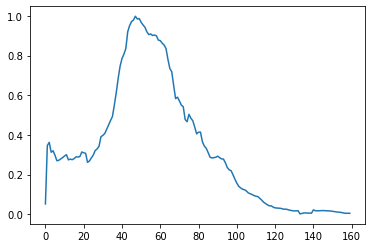

In [22]:
plt.plot(cs_I)

### Boxplot

In [ ]:
# import seaborn as sns
# sns.boxplot(total_cases)

In [ ]:
I

In [ ]:
class PINN_constantParam:
    # Initialize the class
    def __init__(self, t, I, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.t = t
        
        self.I = I
        
        self.layers = layers
        
        self.weights, self.biases = self.initialize_NN(layers)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # initialize params
        self.beta = tf.Variable([300.0], dtype=tf.float32)
        self.Nf = tf.Variable([2.0], dtype=tf.float32)
        self.kappa = tf.Variable([5.0], dtype=tf.float32)
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
                
        
        self.I_predL = self.net_Logistic(self.t_tf)
        
        self.l1, self.l2 = self.net_l(self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.I_tf - self.I_predL)) + \
            tf.reduce_mean(tf.square(self.l1)) + \
            tf.reduce_mean(tf.square(self.l2))
        
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def net_Logistic(self, t):
        Logistic = self.neural_net(t, self.weights, self.biases)
        I = Logistic
        return I
    
    
   
    
    def net_l(self, t):
        Nf = self.Nf
        beta = self.beta
        kappa = self.kappa
        
        I = self.net_Logistic(t)
        I_t = tf.gradients(I, t)[0]
        
        l1 = I - (Nf/(1+beta*tf.math.exp(-kappa*t))) 
        l2 = I_t - (kappa*(I-(1/Nf)*I**2))
        
        return l1, l2
    
    
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.I_tf: self.I}
        start_time = timeit.default_timer()
        tf_dict = {self.t_tf: self.t, self.I_tf: self.I}
        

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                beta_value = self.sess.run(self.beta)
                kappa_value = self.sess.run(self.kappa)
                Nf_value = self.sess.run(self.Nf)
                start_time = timeit.default_timer()
            
            
            # calculate loss with test data
        
        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        I_star = self.sess.run(self.I_predL, tf_dict)
        
        return I_star
        
    
    




In [ ]:
# #########################################################################################################
# # training and testing the network

# niter = 50000  # number of Epochs
# layers = [1, 64, 64, 64, 1]
# t_data = Td.flatten()[:,None]
# I_data = cs_I.flatten()[:,None]    

# from sklearn.model_selection import train_test_split

# # random splits

# T_train, T_test, I_train, I_test = train_test_split(t_data, I_data, test_size = 0.2, random_state = 23)
# T_train = np.sort(T_train, axis = 0)
# T_test = np.sort(T_test, axis = 0)
# I_train = np.sort(I_train, axis = 0)
# I_test = np.sort(I_test, axis = 0)

# # Doman bounds
# lb = t_data.min(0)
# ub = t_data.max(0)

# model = PINN_constantParam(T_test, I_test, layers, lb, ub)
# model.train(niter)


In [ ]:
##########################################################################################################
# training the network

niter = 25000  # number of Epochs
layers = [1, 20, 20, 20, 20, 1]
t_train = Td.flatten()[:,None]
I_train = cs_I.flatten()[:,None] 
#I_train = cs_I.flatten()[:,None]    

# Doman bounds
lb = t_train.min(0)
ub = t_train.max(0)

model = PINN_constantParam(t_train, I_train, layers, lb, ub)
model.train(niter)

In [ ]:
# prediction
I_predL = model.predict(t_train)

In [ ]:
mse_train_loss = model.loss_log
rmse_train_loss = np.sqrt(mse_train_loss)
#print("rmse_train_loss:",*["%.8f"%(x) for x in rmse_train_loss[0:400]])

# flatten array
T0L = Td.flatten()
T1L = t_train.flatten()

# re-scale data
I0L = np.min(I) + (np.max(I) - np.min(I))*cs_I.flatten()
I1L = np.min(I) + (np.max(I) - np.min(I))*I_predL.flatten()

# convert float to list
T0L = T0L[0:nd].tolist()
T1L = T1L[0:nd].tolist()
I0L = I0L[0:nd].tolist()
I1L = I1L[0:nd].tolist()

# print("days:",*["%.8f"%(x) for x in T0[0:nd]])
# print("time:",*["%.8f"%(x) for x in T1[0:nd]])
# print("cases:",*["%.8f"%(x) for x in I0[0:nd]])
# print("infectd:",*["%.8f"%(x) for x in I1[0:nd]])

beta_valueL = model.sess.run(model.beta)
kappa_valueL = model.sess.run(model.kappa)
Nf_valueL = model.sess.run(model.Nf)

# learned parameters
print("beta:",*["%.8f"%(x) for x in beta_valueL])
print("kappa:",*["%.8f"%(x) for x in kappa_valueL])
print("Nf:",*["%.8f"%(x) for x in (np.min(I0L) + (np.max(I0L) - np.min(I0L)))*Nf_valueL])

##########################################################################################################






In [ ]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title('Daily number of individual infectives in Portugal ',fontsize = 20)
ax1.plot(T0L,I0L,'bo')
ax1.plot(T1L, I1L,'g')
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel('Daily Omicron Infection', fontsize = 20)
ax1.legend(('Omicron data','Constant Model'),loc='best',fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

In [ ]:
rmse =np.sqrt(mean_squared_error(I0L, I1L))
rmse

In [ ]:
corr_matrix = np.corrcoef(I0L, I1L)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [ ]:
mapep =  mean_absolute_percentage_error(I0L, I1L)
mapep

In [ ]:
ev = explained_variance_score(I0L, I1L)
ev

### Rational Model

In [ ]:
class PINN_ExpAlpha:
    # Initialize the class
    def __init__(self, t, I,  layers1, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.t = t
        
        self.I = I
        
        self.layers1 = layers1
        
        
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.beta = tf.Variable([5000.0], dtype=tf.float32)
        self.kappa = tf.Variable([1.0], dtype=tf.float32)
        self.d = tf.Variable([1.0], dtype=tf.float32)
        self.Nf = tf.Variable([1.0], dtype=tf.float32)
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        
        
        self.I_predR = self.net_Logistic(self.t_tf)
        self.alpha_predR = self.alphaFunc(self.t_tf)
        
        self.l1 = self.net_l(self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.I_tf - self.I_predR)) + \
                    tf.reduce_mean(tf.square(self.l1)) 
            
            
             
            
        
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_Logistic(self, t):
        Logistic = self.neural_net(t, self.layers1, self.weights1, self.biases1)
        I = Logistic
        return I
    
   
    def alphaFunc(self,t):
        d = self.d
        kappa = self.kappa
        b = kappa*d / (1 + d*t)
        return b
    
    
    def net_l(self, t):
        Nf = self.Nf
        beta = self.beta
        kappa = self.kappa
        d = self.d
        alpha = self.alphaFunc(t)
        
        I = self.net_Logistic(t)
        l1 = I - (Nf/(1+beta*(1 + d*t)**-kappa))
        return l1
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.I_tf: self.I}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                beta_value = self.sess.run(self.beta)
                d_value = self.sess.run(self.d)
                kappa_value = self.sess.run(self.kappa)
                Nf_value = self.sess.run(self.Nf)
                start_time = timeit.default_timer()
        
        
        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        
        I_star = self.sess.run(self.I_predR, tf_dict)
        
        alpha_star = self.sess.run(self.alpha_predR, tf_dict)
        
        return I_star,  alpha_star
        

In [ ]:
##########################################################################################################
# training the network

niter = 25000  # number of Epochs
layers1 = [1, 20, 20, 20, 20, 1]


t_train = Td.flatten()[:,None]
I_train = cs_I.flatten()[:,None]
    
#D_train = cs_D.flatten()[:,None]      

# Doman bounds
lb = t_train.min(0)
ub = t_train.max(0)

model = PINN_ExpAlpha(t_train, I_train, layers1, lb, ub)
model.train(niter)



In [ ]:
# prediction
I_predR, alpha_predR = model.predict(t_train)

In [ ]:
mse_train_loss = model.loss_log
rmse_train_loss = np.sqrt(mse_train_loss)
#print("rmse_train_loss:",*["%.8f"%(x) for x in rmse_train_loss[0:400]])

# flatten array
T0R = Td.flatten()
T1R = t_train.flatten()


# re-scale data
I0R = np.min(I) + (np.max(I) - np.min(I))*cs_I.flatten()
I1R = np.min(I) + (np.max(I) - np.min(I))*I_predR.flatten()
A1R = np.min(I) + (np.max(I) - np.min(I))*alpha_predR.flatten()
#TT1 = np.min(T0) + (np.max(T0) - np.min(T0))*tt

# convert float to list
T0R = T0R[0:nd].tolist()
T1R = T1R[0:nd].tolist()
I0R = I0R[0:nd].tolist()
I1R = I1R[0:nd].tolist()
A1R = A1R[0:nd].tolist()
#TT1 = TT1[0:nd].tolist()

# print("days:",*["%.8f"%(x) for x in T0[0:nd]])
# print("time:",*["%.8f"%(x) for x in T1[0:nd]])
# print("cases:",*["%.8f"%(x) for x in I0[0:nd]])
# print("infectd:",*["%.8f"%(x) for x in I1[0:nd]])

beta_valueR = model.sess.run(model.beta)
kappa_valueR = model.sess.run(model.kappa)
Nf_valueR = model.sess.run(model.Nf)
d_valueR = model.sess.run(model.d)


# learned parameters
print("beta:",*["%.8f"%(x) for x in beta_valueR])
print("kappa:",*["%.8f"%(x) for x in kappa_valueR])
print("Nf:",*["%.8f"%(x) for x in np.min(I0R) + (np.max(I0R) - np.min(I0R))*Nf_valueR])
print("d:",*["%.8f"%(x) for x in d_valueR])


##########################################################################################################





In [ ]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title('Daily number of individual infectives in Portugal',fontsize = 20)
ax1.plot(T0R,I0R,'bo')
ax1.plot(T1R, I1R,'r')
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel('Daily Omicron Infection', fontsize = 20)
ax1.legend(('Omicron data','Rational Model'),loc='best',fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

In [ ]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title(r'$\alpha(t)$ versus $t$ for Rational model',fontsize = 20)
ax1.plot(T1R, alpha_predR.flatten(),'r')
ax1.legend(('Alpha(t)','Logistic Model'),loc='best',fontsize = 20)
ax1.tick_params(axis='both', labelsize = 24)
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel(r'$\alpha(t)$', fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

In [ ]:
rmse =np.sqrt(mean_squared_error(I0R, I1R))
rmse

In [ ]:
corr_matrix = np.corrcoef(I0R, I1R)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mapep =  mean_absolute_percentage_error(I0R, I1R)
mapep

In [ ]:
ev = explained_variance_score(I0R, I1R)
ev

### Birational

In [ ]:
class PINN_ExpAlpha_Birational:
    # Initialize the class
    def __init__(self, t, I,  layers1, X, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.t = t
        
        self.I = I
        
        self.X = X
        
        #self.b = b
        
        
        
       
        
    
        self.layers1 = layers1
        
        
        self.weights1, self.biases1 = self.initialize_NN(layers1)
       
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.beta = tf.Variable([1.0], dtype=tf.float32)
        self.beta1 = tf.Variable([1.0], dtype=tf.float32)
        self.kappa = tf.Variable([1.0], dtype=tf.float32)
        self.kappa1 = tf.Variable([1.0], dtype=tf.float32)
        self.d = tf.Variable([1.0], dtype=tf.float32)
        self.d1 = tf.Variable([1.0], dtype=tf.float32)
        self.c1 = tf.Variable([1.0], dtype=tf.float32)
        self.c = tf.Variable([1.0], dtype=tf.float32)
        self.Nf = tf.Variable([1.0], dtype=tf.float32)
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
                       
        
        self.I_predB = self.net_Logistic(self.t_tf)
        self.alpha_predB = self.alphaFunc(self.t_tf)
        
        
        self.l1,self.l2  = self.net_l(self.t_tf)
             
        self.loss = tf.reduce_mean(tf.square(self.I_tf - self.I_predB)) + \
                    tf.reduce_mean(tf.square(self.l1)) + \
                    tf.reduce_mean(tf.square(self.l2)) 
                    
                    
            
        
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y

   
    
    
    def net_Logistic(self, t):
        Logistic = self.neural_net(t, self.layers1, self.weights1, self.biases1)
        I = Logistic
        return I
    
    
    def alphaFunc(self,t):
        X = self.X
        kappa = self.kappa
        d = self.d
        t1 = t[0:X]
        alp1 = kappa*d / (1 + d*t1)
        
        #b = self.b
        d1 = self.d1
        c1 = self.c1
        Nf = self.Nf
        kappa1 = self.kappa1
        t2 = t[X-1:]
        b1 = kappa1*d1 / (1 + d1*t2)
        b2 = 1 / (1 + ((1 -(c1/Nf))*(1 + d1*t2)**-kappa1))
        alp2 = tf.multiply(b1,b2)
        
        alp =  tf.concat([alp1,alp2],0)
        
        return alp2
        # bound_b = [tf.constant(0.01, dtype=tf.float32), tf.constant(1.0, dtype=tf.float32)] 
        # return bound_b[0]+(bound_b[1]-bound_b[0])*tf.sigmoid(alp2)

    
    
    
    
    def net_l(self, t):
        X = 60
        c = self.c
        c1 = self.c1
        d = self.d
        d1 = self.d1
        beta = self.beta
        beta1 = self.beta1
        kappa = self.kappa
        kappa1 = self.kappa1
        
        
        alpha = self.alphaFunc(t)
        I = self.net_Logistic(t)
        
        I_t = tf.gradients(I, t)[0]
        
        t1 = t[0:X]
        I1 = I[0:X]
        l1 = I1 - (c/(1+beta*(1 + d*t1)**-kappa))
        
        t2 = t[X-1:]
        I2 = I[X-1:]
        l2 = I2 - (((c/(1+beta*(1 + d*X)**-kappa))-(c1/(1+beta1*(1 + d1*X)**-kappa1))+(c1/(1+beta1*(1 + d1*t2)**-kappa1))))
        
        
        
        
        return l1,l2   
    
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.I_tf: self.I}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                beta_value = self.sess.run(self.beta)
                beta1_value = self.sess.run(self.beta1)
                d_value = self.sess.run(self.d)
                d1_value = self.sess.run(self.d1)
                c1_value = self.sess.run(self.c1)
                c_value = self.sess.run(self.c)
                kappa_value = self.sess.run(self.kappa)
                kappa1_value = self.sess.run(self.kappa1)
                Nf_value = self.sess.run(self.Nf)
                start_time = timeit.default_timer()
        
        
        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        
        I_star = self.sess.run(self.I_predB, tf_dict)
        
        alpha_star = self.sess.run(self.alpha_predB, tf_dict)
        
        #tt_star = self.sess.run(self.tt_pred, tf_dict)
        
        return I_star,  alpha_star
        

In [ ]:
##########################################################################################################
# training the network

niter = 25000  # number of Epochs
layers1 = [1, 20, 20, 20, 20, 1]


t_train = Td.flatten()[:,None]
I_train = cs_I.flatten()[:,None]
    
#D_train = cs_D.flatten()[:,None]      

# Doman bounds
lb = t_train.min(0)
ub = t_train.max(0)

model = PINN_ExpAlpha_Birational(t_train, I_train, layers1, 1, lb, ub)
model.train(niter)



In [ ]:
# prediction
I_predB,  alpha_predB = model.predict(t_train)

In [ ]:
mse_train_loss = model.loss_log
rmse_train_loss = np.sqrt(mse_train_loss)
#print("rmse_train_loss:",*["%.8f"%(x) for x in rmse_train_loss[0:400]])

# flatten array
T0B = Td.flatten()
T1B = t_train.flatten()


# re-scale data
I0B = np.min(I) + (np.max(I) - np.min(I))*cs_I.flatten()
I1B = np.min(I) + (np.max(I) - np.min(I))*I_predB.flatten()
A1B = np.min(I) + (np.max(I) - np.min(I))*alpha_predB.flatten()

# convert float to list
T0B = T0B[0:nd].tolist()
T1B = T1B[0:nd].tolist()
I0B = I0B[0:nd].tolist()
I1B = I1B[0:nd].tolist()
A1B = A1B[0:nd].tolist()

# print("days:",*["%.8f"%(x) for x in T0[0:nd]])
# print("time:",*["%.8f"%(x) for x in T1[0:nd]])
# print("cases:",*["%.8f"%(x) for x in I0[0:nd]])
# print("infectd:",*["%.8f"%(x) for x in I1[0:nd]])

beta_valueB = model.sess.run(model.beta)
beta1_valueB = model.sess.run(model.beta1)
kappa_valueB = model.sess.run(model.kappa)
Nf_valueB = model.sess.run(model.Nf)
d_valueB = model.sess.run(model.d)
d1_valueB = model.sess.run(model.d1)
kappa1_valueB = model.sess.run(model.kappa1)
c1_valueB = model.sess.run(model.c1)
c_valueB = model.sess.run(model.c)

# learned parameters
print("beta:",*["%.8f"%(x) for x in beta_valueB])
print("beta1:",*["%.8f"%(x) for x in beta1_valueB])
print("kappa:",*["%.8f"%(x) for x in kappa_valueB])
print("c:",*["%.8f"%(x) for x in np.min(I0B) + (np.max(I0B) - np.min(I0B))*c_valueB])
print("Nf:",*["%.8f"%(x) for x in np.min(I0B) + (np.max(I0B) - np.min(I0B))*Nf_valueB])
print("d:",*["%.8f"%(x) for x in d_valueB])
print("d1:",*["%.8f"%(x) for x in d1_valueB])
print("c1:",*["%.8f"%(x) for x in np.min(I0B) + (np.max(I0B) - np.min(I0B))*c1_valueB])
print("kappa1:",*["%.8f"%(x) for x in kappa1_valueB])

##########################################################################################################





In [ ]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title('Daily number of individual infectives in Portugal',fontsize = 20)
ax1.plot(T0B,I0B,'bo')
ax1.plot(T1B, I1B,'brown')
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel('$I(t)$', fontsize = 20)
ax1.legend(('Omicron data','Birational Model'),loc='best',fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

In [ ]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title(r'$\alpha(t)$ versus $t$ for Birational model',fontsize = 20)
ax1.plot(T1B, alpha_predB.flatten(),'r')
ax1.legend(('Alpha(t)', 'Logistic Model'),loc='best',fontsize = 20)
ax1.tick_params(axis='both', labelsize = 24)
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel(r'$\alpha(t)$', fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

In [ ]:
rmse =np.sqrt(mean_squared_error(I0B, I1B))
rmse

In [ ]:
corr_matrix = np.corrcoef(I0B, I1B)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mapep =  mean_absolute_percentage_error(I0B, I1B)
mapep

In [ ]:
ev = explained_variance_score(I0B, I1B)
ev

### Time Series Model.

In [23]:
class PINN_ExpAlpha_Alpha:
    # Initialize the class
    def __init__(self, t, I,  layers1, layers2, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.t = t
        
        self.I = I
        
        
        
       
        
            
    
        self.layers1 = layers1
        self.layers2 = layers2
        
        
        
        
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
       
        
        
       
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        
        self.Nf = tf.Variable([1.0], dtype=tf.float32)
        
       
        
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
                       
        
        self.I_predA = self.net_Logistic(self.t_tf)
        self.alpha_predA = self.alphaFunc(self.t_tf)
        
        
        self.l1  = self.net_l(self.t_tf)
             
        self.loss = tf.reduce_mean(tf.square(self.I_tf - self.I_predA)) + \
                    tf.reduce_mean(tf.square(self.l1)) 
                     
            
                    
                    
                    
            
        
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    
    
    def neural_net1(self, t, layers2, weights2, biases2):
        num_layers = len(layers2)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y

   
    
    
    
    def net_Logistic(self, t):
        Logistic = self.neural_net(t, self.layers1, self.weights1, self.biases1)
        I = Logistic
        return I
    
    

    def alphaFunc(self,t):
        alpha = self.neural_net1(t, self.layers2, self.weights2, self.biases2)
        alp = alpha
        return alp
        # bound_b = [tf.constant(0.001, dtype=tf.float32), tf.constant(0.5, dtype=tf.float32)] 
        # return bound_b[0]+(bound_b[1]-bound_b[0])*tf.sigmoid(alp)

    
    
    def net_l(self, t):
        Nf = self.Nf
        
        
        alpha = self.alphaFunc(t)
        I = self.net_Logistic(t)
        
        I_t = tf.gradients(I, t)[0]
        
        
        #l1 = I - (Nf/(1+beta*tf.math.exp(-alpha*t)))
        
        l1 = I_t - ((alpha*I)*(1 - I/Nf))
        
        
        return l1
    
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.I_tf: self.I}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                Nf_value = self.sess.run(self.Nf)
                start_time = timeit.default_timer()
        
        
        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        
        I_star = self.sess.run(self.I_predA, tf_dict)
        
        alpha_star = self.sess.run(self.alpha_predA, tf_dict)
        
        
        return I_star,  alpha_star
        

In [24]:
# ##########################################################################################################
# training the network

niter = 25000  # number of Epochs
layers1 = [1, 20, 20, 20, 20, 1]
layers2 = [1, 20, 20, 20, 20, 1]



t_train = Td.flatten()[:,None]
I_train = cs_I.flatten()[:,None]
    
#D_train = cs_D.flatten()[:,None]      

# Doman bounds
lb = t_train.min(0)
ub = t_train.max(0)

model = PINN_ExpAlpha_Alpha(t_train, I_train, layers1, layers2, lb, ub)
model.train(niter)

Device mapping: no known devices.


2022-09-26 23:30:36.861851: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 23:30:36.866123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-26 23:30:36.866159: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-26 23:30:36.866191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-eo3j): /proc/driver/nvidia/version does not exist
2022-09-26 23:30:37.488470: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Var

100%|██████████| 25000/25000 [00:30<00:00, 810.03it/s]


In [25]:
# prediction
I_predA,  alpha_predA = model.predict(t_train)

In [26]:
mse_train_loss = model.loss_log
rmse_train_loss = np.sqrt(mse_train_loss)
#print("rmse_train_loss:",*["%.8f"%(x) for x in rmse_train_loss[0:400]])

# flatten array
T0A = Td.flatten()
T1A = t_train.flatten()


# re-scale data
I0A = np.min(I) + (np.max(I) - np.min(I))*cs_I.flatten()
I1A = np.min(I) + (np.max(I) - np.min(I))*I_predA.flatten()
A1A = np.min(I) + (np.max(I) - np.min(I))*alpha_predA.flatten()

# convert float to list
T0A = T0A[0:nd].tolist()
T1A = T1A[0:nd].tolist()
I0A = I0A[0:nd].tolist()
I1A = I1A[0:nd].tolist()
A1A = A1A[0:nd].tolist()

# print("days:",*["%.8f"%(x) for x in T0[0:nd]])
# print("time:",*["%.8f"%(x) for x in T1[0:nd]])
# print("cases:",*["%.8f"%(x) for x in I0[0:nd]])
# print("infectd:",*["%.8f"%(x) for x in I1[0:nd]])

Nf_valueA = model.sess.run(model.Nf)




# learned parameters
print("Nf:",*["%.8f"%(x) for x in np.min(I0A) + (np.max(I0A) - np.min(I0A))*Nf_valueA])



##########################################################################################################





Nf: 28460.16015625


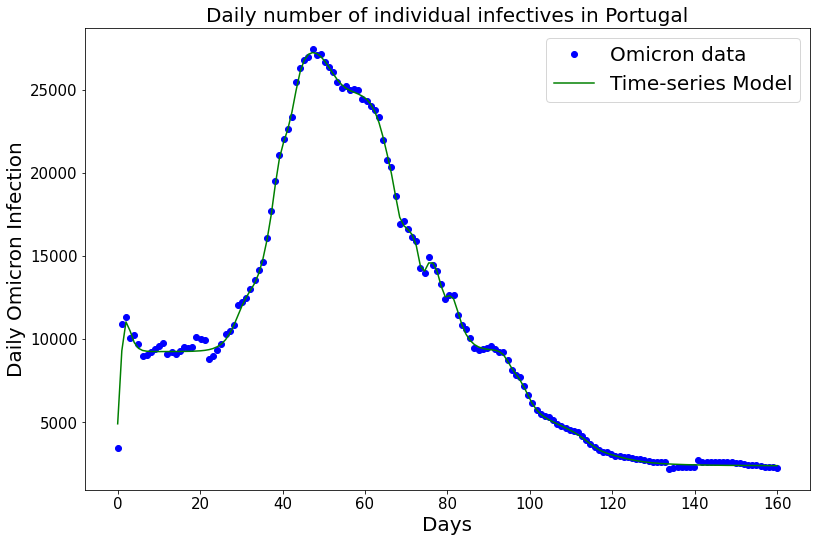

In [27]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title('Daily number of individual infectives in Portugal',fontsize = 20)
ax1.plot(T0A,I0A,'bo')
ax1.plot(T1A, I1A,'g')
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel('Daily Omicron Infection', fontsize = 20)
ax1.legend(('Omicron data','Time-series Model'),loc='best',fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

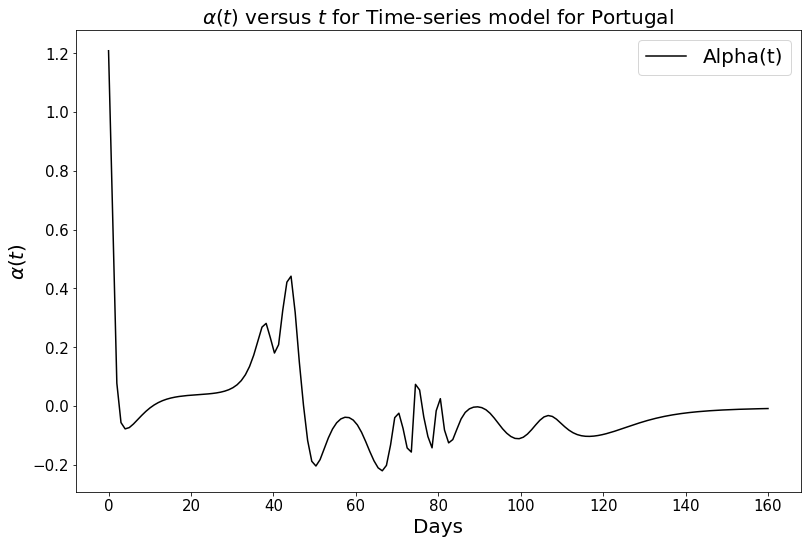

In [28]:
from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title(r'$\alpha(t)$ versus $t$ for Time-series model for Portugal',fontsize = 20)
ax1.plot(T1A, alpha_predA.flatten(),'k')
ax1.legend(('Alpha(t)', 'Logistic Model'),loc='best',fontsize = 20)
ax1.tick_params(axis='both', labelsize = 24)
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel(r'$\alpha(t)$', fontsize = 20)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=15)

In [29]:
rmse =np.sqrt(mean_squared_error(I0A, I1A))
rmse

276.8702393708057

In [30]:
corr_matrix = np.corrcoef(I0A, I1A)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

0.9987925519045082


In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
mapep =  mean_absolute_percentage_error(I0A, I1A)
mapep

2.727204318722605

In [33]:
ev = explained_variance_score(I0A, I1A)
ev

0.9987918121506641

In [34]:
from scipy.integrate import odeint

In [35]:
def function(I, t, alpha, Nf):
    dIdt = alpha*I*(1 - (I/Nf))
    return dIdt

In [36]:
alpha = alpha_predA[-1]
Nf = Nf_valueA
I_p = I_predA[-1]

In [37]:
tt = np.linspace(160,174)
I_PP = np.min(I0A) + (np.max(I0A) - np.min(I0A))*odeint(function, I_p, tt, args=(alpha, Nf))
tt1 =np.linspace(0,160)

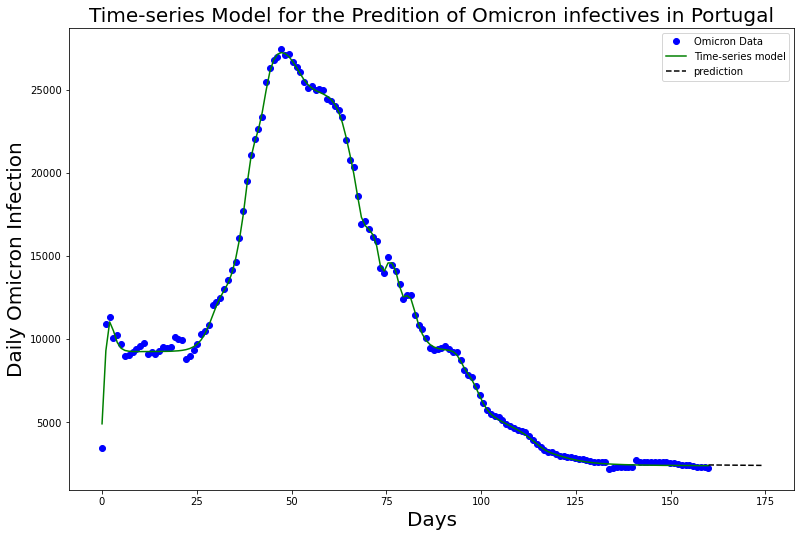

In [38]:

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 7))
#fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(25, 7))


ax1.set_title('Time-series Model for the Predition of Omicron infectives in Portugal',fontsize = 20)
ax1.plot(T0A,I0A,'bo')
ax1.plot(T1A, I1A,'g')
ax1.plot(tt, I_PP,'k--')
ax1.set_xlabel('Days', fontsize = 20)
ax1.set_ylabel('Daily Omicron Infection', fontsize = 20)
ax1.legend(('Omicron Data','Time-series model', 'prediction'),loc='best',fontsize = 10)
fig.set_size_inches(w=13,h=8.5)
ax1.tick_params(labelsize=10)

In [39]:
I_PP[-1]

array([2400.94736183])